## NCM Python Project on Predictive Modelling with a Support Vector Regression

SoSe 2021, SCAN Master FU Berlin


What Data do we have:

From Kaggle TReNDS Competition (https://www.kaggle.com/c/trends-assessment-prediction/data)

#### How Features Were Obtained

An unbiased strategy was utilized to obtain the provided features. This means that a separate, unrelated large imaging dataset was utilized to learn feature templates. Then, these templates were "projected" onto the original imaging data of each subject used for this competition using spatially constrained independent component analysis (scICA) via group information guided ICA (GIG-ICA).

The first set of features are source-based morphometry (SBM) loadings. These are subject-level weights from a group-level ICA decomposition of gray matter concentration maps from structural MRI (sMRI) scans, see the loading.csv file.

The second set are static functional network connectivity (FNC) matrices. These are the subject-level cross-correlation values among 53 component timecourses estimated from GIG-ICA of resting state functional MRI (fMRI), see the fnc.csv file.

#### Outline of this Notebook

* Import and select data for predicting (age & assessment scores)
* Basic exploratory data analysis (EDA), e.g. visualize the data, look at features etc.
* Apply SVR Model
* Model comparison (done collaboratively within our group)



In [1]:
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
from scipy.stats import norm
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
# Import Data

# sMRI SBM loadings for both train and test samples
# these are the independent variables
loading = pd.read_csv('loading.csv')
features = list(loading.columns[1:])
print(features)
# we only wanna predict the age values 
indep_var = ["age"] # "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]

# static FNC correlation features for both train and test samples
fnc = pd.read_csv("fnc.csv")

# these are the dependent variables
targets = pd.read_csv('train_scores.csv')#.set_index('Id')
targets.head()

['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_10', 'IC_09', 'IC_18', 'IC_04', 'IC_12', 'IC_24', 'IC_15', 'IC_13', 'IC_17', 'IC_02', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']


,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


### Data EDA 

* Visualize the data
* Check for missing values
* Analyze the correlation of features 


In [3]:
fnc.describe()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.246927,0.198147,0.520016,0.490069,-0.217425,-0.109341,-0.161214,-0.168549,-0.104565,...,-0.079791,0.324006,0.080442,0.249249,0.469321,0.348458,0.389868,0.142987,0.626399,0.298581
std,3393.231867,0.188442,0.191250,0.149495,0.150758,0.194530,0.183983,0.196940,0.197502,0.222499,...,0.189295,0.179264,0.145512,0.174422,0.195441,0.182376,0.226610,0.200660,0.140739,0.168661
min,10001.000000,-0.629070,-0.554956,-0.483373,-0.209405,-0.798512,-0.713410,-0.798242,-0.851988,-0.861804,...,-0.747646,-0.537107,-0.585412,-0.585195,-0.301003,-0.288560,-0.479468,-0.557574,-0.315752,-0.302054
25%,12939.250000,0.125744,0.075446,0.430992,0.385989,-0.355614,-0.232753,-0.295071,-0.298609,-0.249991,...,-0.211180,0.208489,-0.017199,0.135643,0.336983,0.218694,0.232897,0.005823,0.539361,0.181840
50%,15877.500000,0.251728,0.199320,0.528910,0.486579,-0.215644,-0.104680,-0.149010,-0.158472,-0.095097,...,-0.084883,0.337088,0.082511,0.258028,0.475660,0.339374,0.391916,0.131073,0.636222,0.288689
75%,18815.750000,0.372947,0.323079,0.619095,0.595955,-0.082527,0.015833,-0.022079,-0.030253,0.049065,...,0.048712,0.451829,0.179133,0.370526,0.611851,0.472629,0.556859,0.273020,0.727098,0.410891
max,21754.000000,0.817093,0.929635,0.960302,0.942525,0.897264,0.909322,0.864636,0.540866,0.701827,...,0.589481,0.825865,0.638884,0.766774,0.966800,0.896814,0.938468,0.830948,0.960858,0.853940


In [4]:
loading.describe()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.005423,0.009251,0.010635,0.001054,-0.001271,0.013410,0.013749,0.001988,0.005053,...,0.010036,0.020869,0.009754,-0.008081,0.023412,0.005084,0.003595,-0.014729,0.026623,0.016187
std,3393.231867,0.004552,0.004153,0.003609,0.003591,0.002658,0.004032,0.003905,0.003200,0.005296,...,0.003914,0.003542,0.004609,0.003267,0.004578,0.003697,0.002846,0.005972,0.004039,0.003731
min,10001.000000,-0.015894,-0.015927,-0.002240,-0.013459,-0.015118,-0.002929,0.001156,-0.009622,-0.027575,...,-0.005282,0.008878,-0.010426,-0.020051,0.008485,-0.007969,-0.007720,-0.040384,0.013261,0.001266
25%,12939.250000,0.002527,0.006495,0.008159,-0.001319,-0.002904,0.010764,0.011048,-0.000185,0.002079,...,0.007356,0.018471,0.006692,-0.010231,0.020266,0.002550,0.001677,-0.018738,0.023791,0.013595
50%,15877.500000,0.005546,0.009192,0.010572,0.000956,-0.001132,0.013513,0.013545,0.001917,0.005605,...,0.009942,0.020620,0.009860,-0.008101,0.023231,0.004953,0.003539,-0.014498,0.026411,0.016031
75%,18815.750000,0.008476,0.011990,0.013009,0.003432,0.000535,0.016087,0.016186,0.004113,0.008734,...,0.012616,0.023098,0.012876,-0.005915,0.026302,0.007421,0.005454,-0.010635,0.029244,0.018599
max,21754.000000,0.024189,0.029621,0.026218,0.022613,0.007863,0.028797,0.035586,0.015763,0.022121,...,0.028522,0.036454,0.026258,0.005262,0.045043,0.029049,0.016599,0.005710,0.044570,0.032066


age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

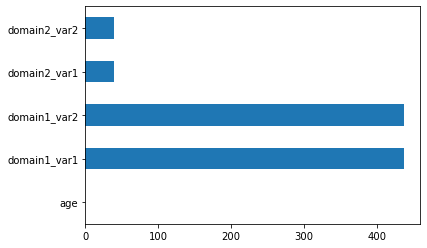

In [5]:
# How many null values does each target have
n_nulls = targets.iloc[:,1:].isnull().sum()
display(n_nulls)
n_nulls.plot.barh()
plt.show()

### Handling the missing Value...

Handling missing values is an essential part of data cleaning and preparation process because almost all data in real life comes with some missing values.

Missing values need to be handled because they reduce the quality for any of our performance metric. It can also lead to wrong prediction or classification and can also cause a high bias for any given model being used.
WHAT DO WE DO TO MISSING VALUES?

There are several options for handling missing values each with its own PROS and CONS. However, the choice of what should be done is largely dependent on the nature of our data and the missing values. Below is a summary highlight of several options we have for handling missing values.

* DROP MISSING VALUES
* FILL MISSING VALUES WITH TEST STATISTIC (mean, median, mode).
* PREDICT MISSING VALUE WITH A MACHINE LEARNING ALGORITHM (knn).



In [6]:
# either drop or we leave them in and deal with them when applying a svr to each target feature
#targets.fillna(targets.mean(),inplace=True)
targets.dropna(inplace=True)

In [7]:
print(targets.info())
print(fnc.info())
loading.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 5876
Data columns (total 6 columns):
Id              5434 non-null int64
age             5434 non-null float64
domain1_var1    5434 non-null float64
domain1_var2    5434 non-null float64
domain2_var1    5434 non-null float64
domain2_var2    5434 non-null float64
dtypes: float64(5), int64(1)
memory usage: 297.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11754 entries, 0 to 11753
Columns: 1379 entries, Id to CBN(7)_vs_CBN(4)
dtypes: float64(1378), int64(1)
memory usage: 123.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11754 entries, 0 to 11753
Data columns (total 27 columns):
Id       11754 non-null int64
IC_01    11754 non-null float64
IC_07    11754 non-null float64
IC_05    11754 non-null float64
IC_16    11754 non-null float64
IC_26    11754 non-null float64
IC_06    11754 non-null float64
IC_10    11754 non-null float64
IC_09    11754 non-null float64
IC_18    11754 non-null float64
IC

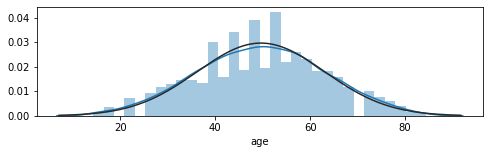

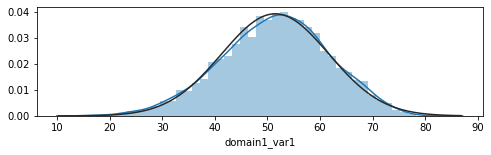

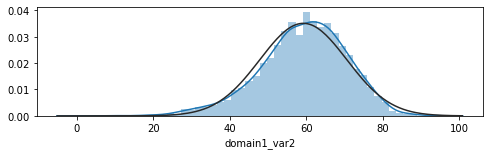

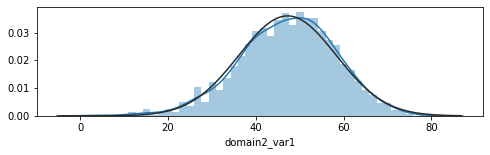

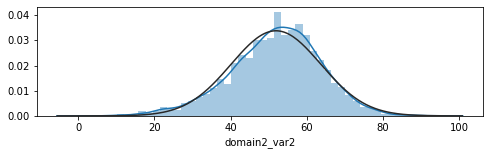

In [8]:
#Look at target distributions
from scipy.stats import norm
for col in targets.columns[1:]:
    plt.figure(figsize=(8, 2))
    sns.distplot(targets[col], fit=norm, kde=True) #stat = 'density', kde = True, bins= 30)
    #sns.distplot(train_df[col], fit=norm, kde=True)
    plt.show()
#looks pretty normal

#### Let's look at the correlation heatmap for variables we want to predict

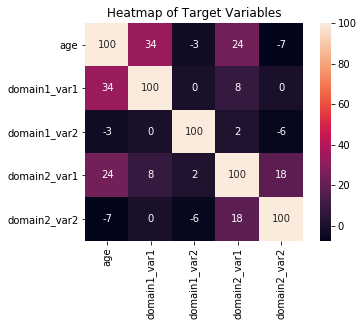

In [9]:
sns.heatmap(targets.iloc[:,1:].corr()*100, square=True, annot=True, fmt='.0f')
plt.title('Heatmap of Target Variables')
plt.show()

#### Let's look at the correlation heatmap for the features we will use for the prediction

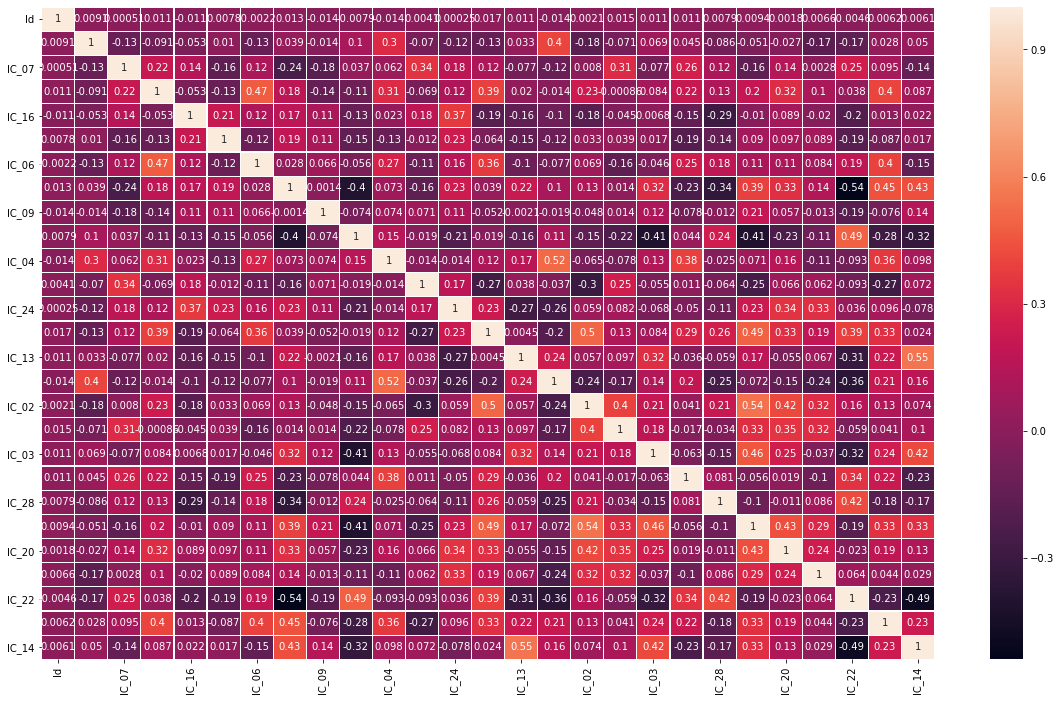

In [10]:
sns.heatmap(loading.corr(),annot=True,linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()


#### Interpreting The Heatmap 

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.


For the target features, there is a slight correlation between var 1 and var 2 for domain 2, there doesn't seem to be one within domain 1. So, while the target features (in domain 1) were measured in the same domain, they do not necessarily encode a connected property. 

For the features we will use for the prediction, some seem to have a pretty high correlation (> 0.5), meaning the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. 

So do we  use both of them as one of them is redundant? While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages. So let's take out features with correlation values above 0.5:


In [11]:
# take out features (ICs) used for prediction that have a correlation above 0.5
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(loading, 10)) # get rid of IC 13,2,10,4
#print(get_top_abs_correlations(fnc, 10)) # does not make sene for fnc values as they are correlation scores 
# indicating how correlated two brain regions are within a subject

Top Absolute Correlations
IC_13  IC_14    0.549198
IC_02  IC_11    0.541680
IC_10  IC_22    0.539141
IC_04  IC_17    0.517069
IC_15  IC_02    0.502258
IC_22  IC_14    0.490677
IC_15  IC_11    0.489176
IC_18  IC_22    0.486763
IC_05  IC_06    0.473493
IC_03  IC_11    0.456074
dtype: float64


In [12]:
print('ICs (before): \n{}'.format(np.sort(loading.columns)), sep='')
loading = loading.drop(['IC_02', 'IC_04', 'IC_10', 'IC_13'], 1)
print('\nICs (after): \n{}'.format(np.sort(loading.columns)), sep='')
#we also need to update our loadings names (features), since that list contains the removed ICs
print('\n\nloading_names (before): \n{}'.format(features))
features = list(loading.columns[1:])
print('\nloading_names (updated): \n{}'.format(features))

ICs (before): 
['IC_01' 'IC_02' 'IC_03' 'IC_04' 'IC_05' 'IC_06' 'IC_07' 'IC_08' 'IC_09'
 'IC_10' 'IC_11' 'IC_12' 'IC_13' 'IC_14' 'IC_15' 'IC_16' 'IC_17' 'IC_18'
 'IC_20' 'IC_21' 'IC_22' 'IC_24' 'IC_26' 'IC_28' 'IC_29' 'IC_30' 'Id']

ICs (after): 
['IC_01' 'IC_03' 'IC_05' 'IC_06' 'IC_07' 'IC_08' 'IC_09' 'IC_11' 'IC_12'
 'IC_14' 'IC_15' 'IC_16' 'IC_17' 'IC_18' 'IC_20' 'IC_21' 'IC_22' 'IC_24'
 'IC_26' 'IC_28' 'IC_29' 'IC_30' 'Id']


loading_names (before): 
['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_10', 'IC_09', 'IC_18', 'IC_04', 'IC_12', 'IC_24', 'IC_15', 'IC_13', 'IC_17', 'IC_02', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']

loading_names (updated): 
['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_09', 'IC_18', 'IC_12', 'IC_24', 'IC_15', 'IC_17', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11', 'IC_20', 'IC_30', 'IC_22', 'IC_29', 'IC_14']


### Visualizing the target columns

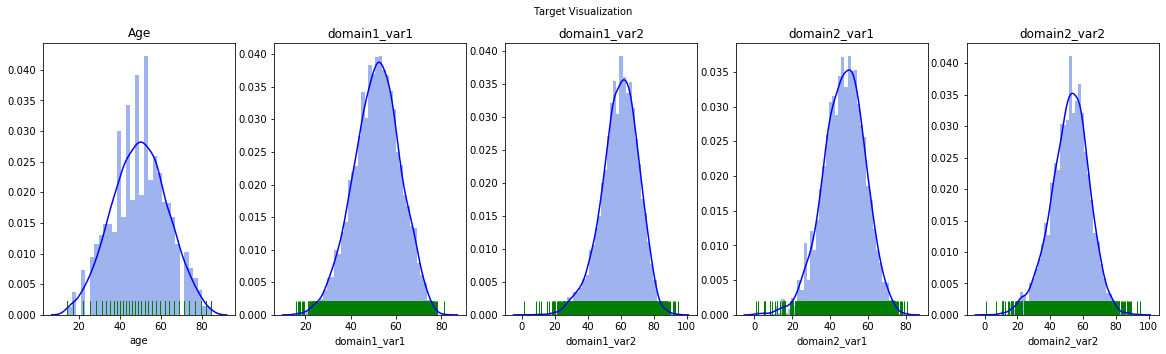

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
sns.distplot(targets['age'], ax=ax[0],rug=True, rug_kws={"color": "green"},
                  kde_kws={"color": "blue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 0.5, "color": "royalblue"}).set_title('Age')

sns.distplot(targets['domain1_var1'], ax=ax[1],rug=True, rug_kws={"color": "green"},
                  kde_kws={"color": "blue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 0.5, "color": "royalblue"}).set_title('domain1_var1')

sns.distplot(targets['domain1_var2'], ax=ax[2],rug=True, rug_kws={"color": "green"},
                  kde_kws={"color": "blue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 0.5, "color": "royalblue"}).set_title('domain1_var2')

sns.distplot(targets['domain2_var1'], ax=ax[3],rug=True, rug_kws={"color": "green"},
                  kde_kws={"color": "blue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 0.5, "color": "royalblue"}).set_title('domain2_var1')

sns.distplot(targets['domain2_var2'], ax=ax[4],rug=True, rug_kws={"color": "green"},
                  kde_kws={"color": "blue", "lw": 1.5},
                  hist_kws={"histtype": "bar", "linewidth": 3,
                            "alpha": 0.5, "color": "royalblue"}).set_title('domain2_var2')

fig.suptitle('Target Visualization', fontsize=10)
plt.show()

<Figure size 1440x1080 with 0 Axes>

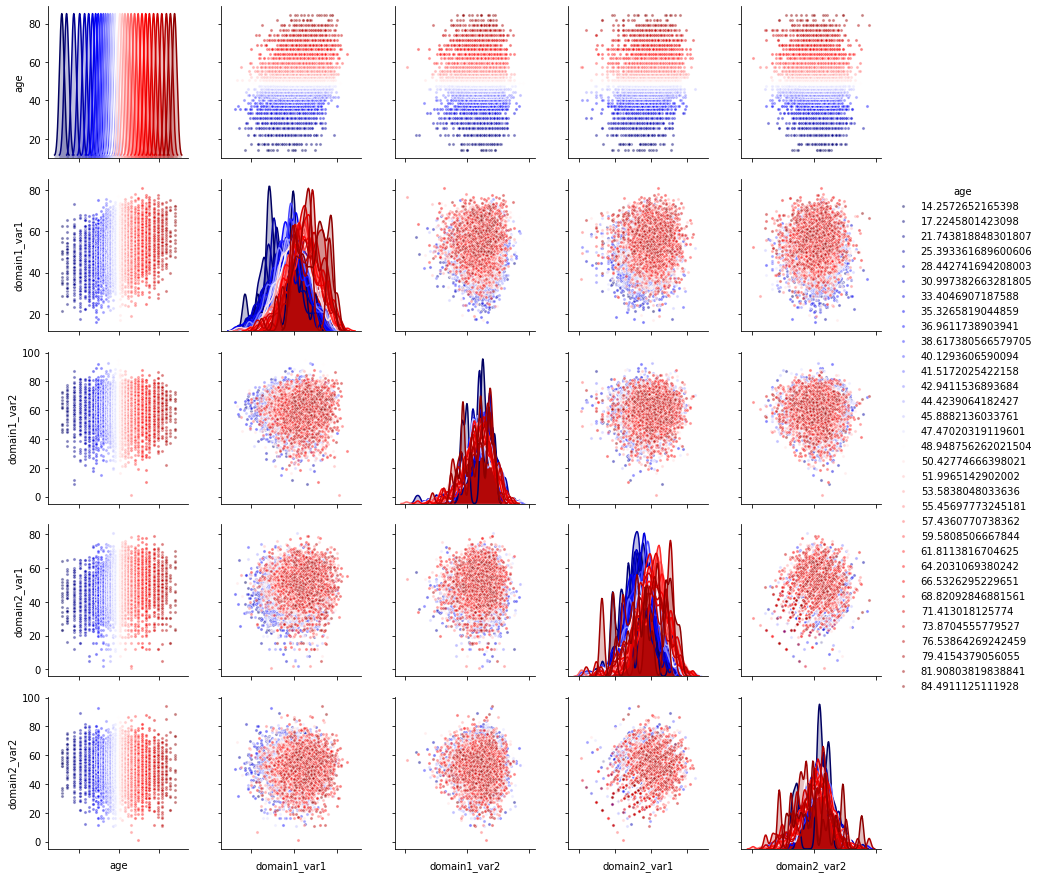

In [14]:
plt.figure(figsize=(20,15))
g = sns.pairplot(data=targets.iloc[:,1:], hue='age', palette = 'seismic', diag_kws={'bw': 1.5},
                 diag_kind = 'kde',plot_kws=dict(s=10, alpha=0.5) )
g.set(xticklabels=[])
plt.show()

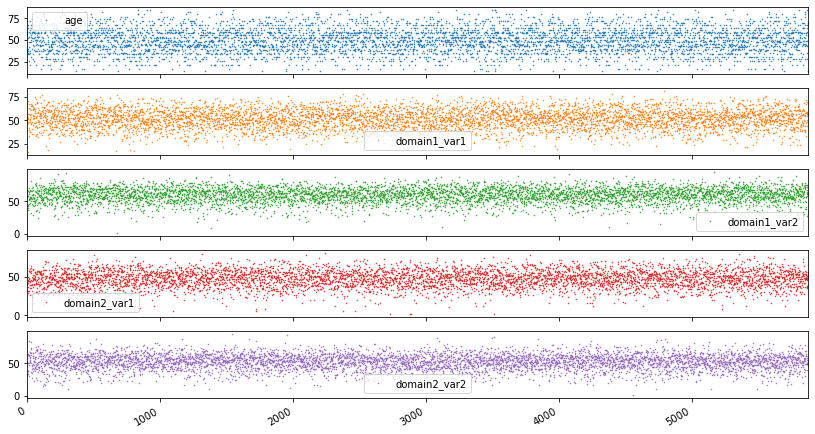

In [15]:
targets.iloc[:,1:].plot(lw=0, marker='.', markersize=1, subplots=True, figsize=(14, 8))
plt.show()

Age looks like it has discrete categories, let's check:

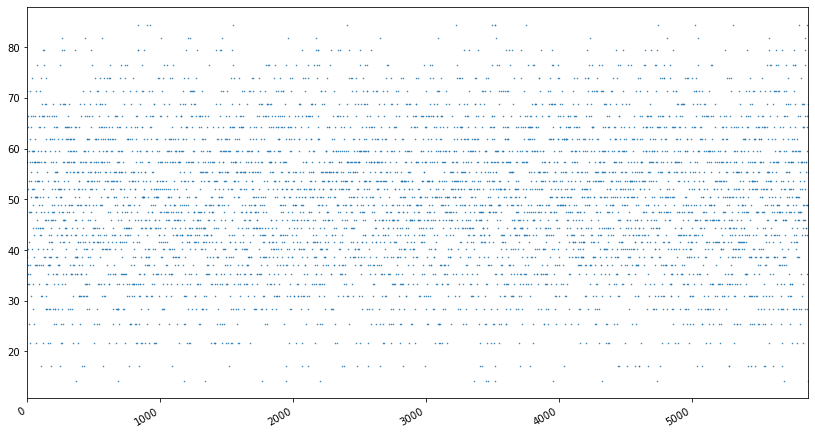

In [16]:
# as we're only interested in predicting the age, let's have a closer look 
# what we see is a stratification of the age column
targets['age'].plot(lw=0, marker='.', markersize=1, subplots=True, figsize=(14, 8))
plt.show()

33
[14.25726522 17.22458014 21.74381885 25.39336169 28.44274169 30.99738266
 33.40469072 35.3265819  36.96117389 38.61738057 40.12936066 41.51720254
 42.94115369 44.42390642 45.8882136  47.47020319 48.94875626 50.42774666
 51.99651429 53.5838048  55.45697773 57.43607707 59.58085067 61.81138167
 64.20310694 66.53262952 68.82092847 71.41301813 73.87045558 76.53864269
 79.41543791 81.9080382  84.49111251]


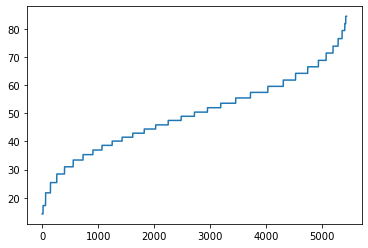

In [17]:
print(targets['age'].nunique())
print(np.sort(targets['age'].unique()))
#distribution of age over target
plt.plot(targets['age'].sort_values().values)
plt.show()

#### The plots above show us a clear stratification of our age variable.
If we try to predict this feature, it might be worth it to restrict the predictions to these 33 unique values or do a classification instead of regression?

#### We will need a metric for evaluating our model 

So let's create a function that gives us back scores, both the R2 and the Mean Absolute Percentage Error


In [18]:
# function for evaluating our model, gives us back R2 and MAPE scores
def print_scores(ytrue, ypred):
    print('total R2: ', metrics.r2_score(y_true=ytrue, y_pred=ypred))
    print('\nMean Absolute Percentage Error: ', np.mean(np.sum(np.abs(ytrue - ypred), axis=0)/np.sum(ytrue, axis=0)))
    #return np.mean(np.sum(np.abs(ytrue - ypred), axis=0)/np.sum(ytrue, axis=0))


In [19]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

In [20]:
loading.describe()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_09,IC_18,IC_12,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.005423,0.009251,0.010635,0.001054,-0.001271,0.013410,0.001988,0.005053,-0.003557,...,0.010036,0.020869,0.009754,-0.008081,0.023412,0.005084,0.003595,-0.014729,0.026623,0.016187
std,3393.231867,0.004552,0.004153,0.003609,0.003591,0.002658,0.004032,0.003200,0.005296,0.004567,...,0.003914,0.003542,0.004609,0.003267,0.004578,0.003697,0.002846,0.005972,0.004039,0.003731
min,10001.000000,-0.015894,-0.015927,-0.002240,-0.013459,-0.015118,-0.002929,-0.009622,-0.027575,-0.022955,...,-0.005282,0.008878,-0.010426,-0.020051,0.008485,-0.007969,-0.007720,-0.040384,0.013261,0.001266
25%,12939.250000,0.002527,0.006495,0.008159,-0.001319,-0.002904,0.010764,-0.000185,0.002079,-0.006481,...,0.007356,0.018471,0.006692,-0.010231,0.020266,0.002550,0.001677,-0.018738,0.023791,0.013595
50%,15877.500000,0.005546,0.009192,0.010572,0.000956,-0.001132,0.013513,0.001917,0.005605,-0.003636,...,0.009942,0.020620,0.009860,-0.008101,0.023231,0.004953,0.003539,-0.014498,0.026411,0.016031
75%,18815.750000,0.008476,0.011990,0.013009,0.003432,0.000535,0.016087,0.004113,0.008734,-0.000766,...,0.012616,0.023098,0.012876,-0.005915,0.026302,0.007421,0.005454,-0.010635,0.029244,0.018599
max,21754.000000,0.024189,0.029621,0.026218,0.022613,0.007863,0.028797,0.015763,0.022121,0.026046,...,0.028522,0.036454,0.026258,0.005262,0.045043,0.029049,0.016599,0.005710,0.044570,0.032066


In [21]:
# Transform data
# saving the names of the columns/features in a list
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

# merge the two dfs into one, so add the features, row # doesn't change as it's merged on the subjects
#df = fnc.merge(loading, on="Id")

df = loading.merge(targets, on="Id", how="left")
df = df.dropna()
#loading_all= targets.merge(loading, on="Id")

In [22]:
print(df.shape)

(5434, 28)


In [23]:
train_df, test_df = train_test_split(df, test_size=0.33, shuffle=True)

In [24]:
tuned_parameters = [{'kernel': ['rbf'], 'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

SVRreg = SVR(cache_size=3000.0)    


Let's do a quick GridSearch to find the best hyperparameters for our support vector regressor:

In [25]:
GridS = GridSearchCV(SVRreg, param_grid=tuned_parameters)
GridS.fit(train_df[features], train_df['age'])
print('Best Parameters: {} \n'.format(GridS.best_params_))
print_scores(ytrue=test_df['age'], ypred=GridS.predict(test_df[features]))

Best Parameters: {'C': 1000, 'kernel': 'linear'} 

total R2:  0.43093319643279493

Mean Absolute Percentage Error:  0.15842051274953478


In [26]:
model = SVR(kernel='linear', C=1000, cache_size=3000.0)
model.fit(train_df[features], train_df['age'])
print("Accuracy score of Support Vector Regressor on age in training set (R2)")
print(model.score(train_df[features], train_df['age']))

Accuracy score of Support Vector Regressor on age in training set (R2)
0.43938153753475157


In [27]:
y_predicted = model.predict(test_df[features])

print("Accuracy score of Support Vector Regressor on predicting age in test set (R2)")
print(model.score(test_df[features], test_df['age']))

Accuracy score of Support Vector Regressor on predicting age in test set (R2)
0.43093319643279493


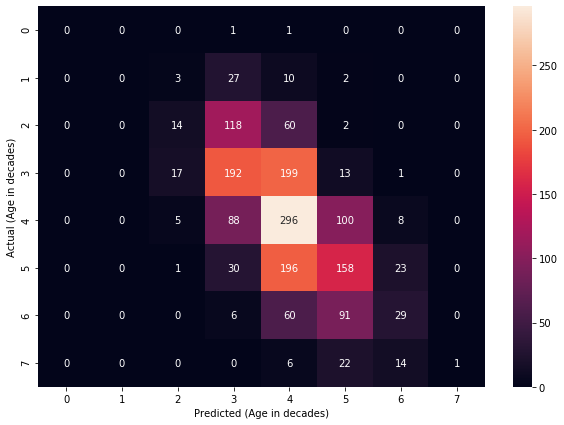

In [28]:
# Let's have a look at how well we predicted ages
# convert our prediction to a classification by decade of age
# and plot of confusion matrix to show the accuracy of our prediction
cm = metrics.confusion_matrix(test_df["age"].round(-1).astype(int), y_predicted.round(-1).astype(int))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt = "d")
plt.xlabel('Predicted (Age in decades)')
plt.ylabel('Actual (Age in decades)')
plt.show()

Given the R2 value, it can be referred that around 44% of the changeability of the dependent output attribute can be explained by the model while the remaining 66% of the variability is still unaccounted for.
R2 indicates the proportion of data points which lie within the line created by the regression equation. Our r2 value is indicating okay results. The fit of our model could possibly be improved by including all features (i.e. also the fnc features). Also, remember that the variable we're trying to predict (age) is dicrete. A logistic regression or classification might lead to better results as well.

In [29]:
###########################################################################################################
#                                     Collaborative Model Comparison                                      #
# After completing our individual projects above, students who used the same kaggle dataset collaborated  #
# to produce a model comparison between these different regression models, which can be shown below. We   #
# will only be looking at the prediction of age for the comparison:      



# run cross validation on my model
seed = 7
scoring = 'r2'
kfold = KFold(n_splits=10, random_state=seed)
cv_results = cross_val_score(model, df[features], df["age"].astype(int), cv=kfold, scoring=scoring)

In [30]:
# let's have a look at our scores of the SVR 
# one score per run of the cross validation
print(cv_results)

[0.43295233 0.43453812 0.43081814 0.40258886 0.45702201 0.4329985
 0.42734786 0.39751439 0.46639111 0.46734562]


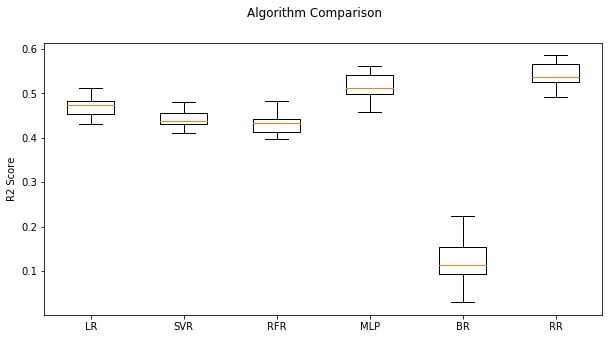

In [31]:
results = [
    [0.48038686, 0.44722758, 0.47229537, 0.43149557, 0.48267628, 0.47303389,
       0.47288577, 0.43150015, 0.50556724, 0.51195019], # LinearRegression
    [0.4330323, 0.4415893, 0.43576118, 0.41260509, 0.45900908, 0.44424805, 
     0.4300585, 0.41139041, 0.47555739, 0.480079], #SVR
    [0.43819714, 0.40940325, 0.45465441, 0.40138206, 0.43437831,
       0.44386384, 0.42308454, 0.39606003, 0.48182481, 0.43259663], #RandomForestRegressor
    [0.48602632, 0.50945147, 0.54282255, 0.51462939, 0.54125916,
        0.50663771, 0.49722094, 0.45733866, 0.53932954, 0.56163937], # MLPRegressor
    [0.02901306, 0.15196958, 0.08661957, 0.1940907 , 0.11258754,
        0.11474175, 0.15555495, 0.10880699, 0.03113268, 0.22320099], # BaggingRegressor
    [0.5222,0.5109,0.5340,0.4915,0.5440,0.5819,0.5384,0.5855,0.5720,0.5368] #RidgeRegressions
]
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["LR", "SVR", "RFR", "MLP", "BR", "RR"])
plt.ylabel("R2 Score")
plt.show()

In [34]:
labels_df = pd.read_csv("train_scores.csv")
labels_df["is_train"] = True
df = loading.merge(labels_df, on="Id", how="left")
#df = df.dropna()
print(df.shape)
#print(df.head())
test_df_true = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

(11754, 29)


In [35]:
print(df.shape)
print(test_df.shape)

(5877, 29)
(5877, 29)


In [36]:
# train SVR
# using KFold for splitting train scores into train and test sets
# remember train scores gives true underlying data but not for all subjects
# Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

accuracy_scores = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)


overal_score = 0
target = 'age'


y_oof = np.zeros(df.shape[0])
y_test = np.zeros((test_df.shape[0], 10))

# for fold and train index and validation index
for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
    print('Fold {}'.format(f))
    train_df, test_df = df.iloc[train_ind], df.iloc[val_ind]
    # make sure there are no nan values 
    train_df = train_df[train_df[target].notnull()]
   # print(train_df[features])
   # print(train_df['age'])
    print(train_df[features].shape)
    print(train_df[target].shape)

    # c is regularization parameter for svr, GridSearch CV revealed linear kernel and C of 1000
    model = SVR(kernel='linear', C=1000, cache_size=3000.0)
    
    model.fit(train_df[features], train_df[target])
    print("Accuracy score of Support Vector Regressor on age in training set (R2)")
    print(model.score(train_df[features], train_df[target]))
    
    # Now we can create predictions and evaluate our model
    y_predicted = model.predict(test_df[features])

    print("Accuracy score of Support Vector Regressor on predicting age in test set (R2)")
    print(model.score(test_df[features], test_df[target]))
    accuracy_scores.append(model.score(test_df[features], test_df[target]))

    y_oof[val_ind] = y_predicted
    # this is the prediction for the unknown target data (train scores)
    y_test[:, f] = model.predict(test_df_true[features])
   # print(y_test)

df["pred_age"] = y_oof
print(y_test.mean(axis=1))
test_df_true[target] = y_test.mean(axis=1)


score = print_scores(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)



Fold 0
(5289, 22)
(5289,)
Accuracy score of Support Vector Regressor on age in training set (R2)
0.44603193094553806
Accuracy score of Support Vector Regressor on predicting age in test set (R2)
0.4565728325974241
Fold 1
(5289, 22)
(5289,)
Accuracy score of Support Vector Regressor on age in training set (R2)
0.4498782432402362
Accuracy score of Support Vector Regressor on predicting age in test set (R2)
0.43176191268303943
Fold 2
(5289, 22)
(5289,)
Accuracy score of Support Vector Regressor on age in training set (R2)
0.4506738173459789
Accuracy score of Support Vector Regressor on predicting age in test set (R2)
0.4180070021712765
Fold 3
(5289, 22)
(5289,)
Accuracy score of Support Vector Regressor on age in training set (R2)
0.43830228011236444
Accuracy score of Support Vector Regressor on predicting age in test set (R2)
0.5124397345738061
Fold 4
(5289, 22)
(5289,)
Accuracy score of Support Vector Regressor on age in training set (R2)
0.45031316027327806
Accuracy score of Support Ve

#### Saving the predicted age values in dataframe

In [37]:
sub_df = pd.melt(test_df[["Id", "age"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")
#sub_df['r2'] = results
sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
#assert sub_df.shape[0] == test_df.shape[0]*5
sub_df



,Id,Predicted
0,10001_age,57.436077
1,10051_age,35.326582
2,10058_age,21.743819
3,10061_age,61.811382
4,10132_age,57.436077
5,10182_age,61.811382
6,10184_age,64.203107
7,10189_age,44.423906
8,10191_age,50.427747
9,10208_age,44.423906


#### Loading the dataframe that I saved when I ran the above SVR with all target features and not only age

In [38]:
sub = pd.read_csv("submission.csv")
#sub_df.to_csv("submission.csv", index=False)
sub

,Id,Predicted
0,10003_age,50.341283
1,10003_domain1_var1,51.844107
2,10003_domain1_var2,60.058040
3,10003_domain2_var1,47.849567
4,10003_domain2_var2,52.630740
5,10006_age,50.365600
6,10006_domain1_var1,51.845550
7,10006_domain1_var2,60.057829
8,10006_domain2_var1,47.850276
9,10006_domain2_var2,52.630026
